In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

import glob
import time
import sklearn.svm as svm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from skimage.feature import hog
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV




In [2]:
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# class save_images ( object ):
#     def __init__( self ):
#         self.i = 0
#     def __call__( self, image):
#         # do somethingc
#         self.i +=1
#         cv2.imwrite("test_images2/image" + str(self.i) + ".jpg", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
#         return image
    
# save_images = save_images()    
    
# ## creating additional test images
# from moviepy.editor import VideoFileClip
# output_video_name = 'test_video_output.mp4'
# clip1 = VideoFileClip("test_video.mp4")
# clip2 = clip1.subclip(0,2)
# output_video = clip2.fl_image(save_images) #NOTE: this function expects color images!!
# %time output_video.write_videofile(output_video_name, audio=False)
# import os
# os.remove('test_video_output.mp4')
# print ("Completed")


## image_features_extractor

In [3]:
class image_features_extractor:
    def __init__(self    \
        ,color_space           # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        ,orient                # HOG orientations 
        ,pix_per_cell          # HOG pixels per cell 
        ,cell_per_block        # HOG cells per block 
        ,spatial_size          # Spatial binning dimensions
        ,spatial_feat          # Spatial features on or off
        ,hist_feat             # Histogram features on or off
        ,hog_feat              # HOG features on or off
        ,nbins                 # Number of color histogram bins
        ,bins_range
        ,image_size
        ,debug=False
                ):

        self.color_space = color_space
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.spatial_size = spatial_size
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        self.nbins=nbins
        self.bins_range=bins_range
        self.debug =debug
        self.image_size = image_size

    # Define a function to compute binned color features  
    def bin_spatial(self,feature_image):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(feature_image, self.spatial_size).ravel() 
        # Return the feature vector
        return features

    # Define a function to compute color histogram features  
    def color_hist(self,feature_image):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(feature_image[:,:,0], bins=self.nbins, range=self.bins_range)
        channel2_hist = np.histogram(feature_image[:,:,1], bins=self.nbins, range=self.bins_range)
        channel3_hist = np.histogram(feature_image[:,:,2], bins=self.nbins, range=self.bins_range)
        # Concatenate the histograms into a single feature vector
        self.hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
#         hist_features = channel1_hist[0]

        if self.debug:
            # Generating bin centers
            bin_edges = channel1_hist[1]
            bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
            # Plot a figure with all three bar charts
            fig = plt.figure(figsize=(12,3))
            plt.subplot(131)
            plt.bar(bin_centers, channel1_hist[0])
            plt.xlim(0, 256)
            plt.title('Channel 0 Histogram')
            plt.subplot(132)
            plt.bar(bin_centers, channel2_hist[0])
            plt.xlim(0, 256)
            plt.title('Channel 1 Histogram')
            plt.subplot(133)
            plt.bar(bin_centers, channel3_hist[0])
            plt.xlim(0, 256)
            plt.title('Channel 2 Histogram')
            plt.show()

       
        # Return the individual histograms, bin_centers and feature vector
        return self.hist_features

    def get_hog_features(self, feature_image):
        if self.debug:
            # feature_image is 1 channel image
            hog_features ,hog_image    = hog(feature_image, 
                                  orientations=self.orient, 
                                  pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                                  cells_per_block=(self.cell_per_block, self.cell_per_block), 
                                  block_norm='L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=True, feature_vector=True)

            plt.imshow(hog_image)
            plt.title("Histogram of Oriented Gradients")
            plt.axis("off")
            plt.show()
            return hog_features

        
        else:
            # feature_image is 1 channel image
            hog_features     = hog(feature_image, 
                                  orientations=self.orient, 
                                  pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                                  cells_per_block=(self.cell_per_block, self.cell_per_block), 
                                  block_norm='L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=False, feature_vector=True)
            return hog_features



    def get_all_features (self, img):
        if self.debug:
            print( "get_all_features image shape "+ str(img.shape))
        if self.color_space != 'RGB':
            if self.color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif self.color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif self.color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif self.color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif self.color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)
            
        
        if feature_image.shape[0] == self.image_size[0] and\
           feature_image.shape[1] == self.image_size[1]:
            pass #print (" feature_image.shape == self.image_size")
        else:
             print (" feature_image.shape = " + str(feature_image.shape))
             print (" self.image_size = "     + str(self.image_size))
             feature_image = cv2.resize(feature_image, self.image_size)    
                
        if self.debug:
            f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
            f.tight_layout()
            

            ax1.imshow(feature_image[:,:,0],cmap="gray")
            ax1.set_title("Image in format " + self.color_space + " channel 0 ")
            ax1.axis('off')
            
            ax2.imshow(feature_image[:,:,1],cmap="gray")
            ax2.set_title("Image in format " + self.color_space+ " channel 1 ")
            ax2.axis('off')

            ax3.imshow(feature_image[:,:,2],cmap="gray")
            ax3.set_title("Image in format " + self.color_space+ " channel 2 ")
            ax3.axis('off')

            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
            plt.show()


            
        img_features = []

        if self.spatial_feat == True:
            img_features.append(self.bin_spatial(feature_image))

        if self.hist_feat == True:
            img_features.append(self.color_hist(feature_image))
            
        if self.hog_feat == True:
#             gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#             hog_features = self.get_hog_features(gray_image)
            hog_features = []
            for channel in range(feature_image.shape[2]):
                temp = self.get_hog_features(feature_image[:,:,channel])
                hog_features.extend(temp)      
            img_features.append(hog_features)
            
        #9) Return concatenated array of features
    #     print (img_features)
        return np.concatenate(img_features)                
    

### Car Detector from images ( train & prediction )

In [4]:
class image_car_detector:
    def __init__(self, extractor, 
                 cars_folder='vehicles', 
                 notcars_folder='non-vehicles',
                 limit_images=None):
        self.cars_folder    = cars_folder
        self.notcars_folder = notcars_folder

        self.car_images_list     = []
        self.notcars_images_list = []
        self.extractor = extractor
        
        self.car_features = []
        self.notcar_features = []
        self.limit_images = limit_images

        
    def load_images_list(self):
        self.car_images_list     = []
        self.notcars_images_list = []
    
        # loading cars
        for subfolder in glob.glob(self.cars_folder + '/*'):
          print ("subfolder = " + subfolder)
          for image  in  glob.glob(subfolder+'/*'):
               self.car_images_list.append(image)

        # loading non cars
        for subfolder in glob.glob(self.notcars_folder+ '/*'):
          for image  in  glob.glob(subfolder+'/*'):
               self.notcars_images_list.append(image)
    
    # Define a function to extract features from a list of images
    # Have this function call bin_spatial() and color_hist()
    def extract_imgs_features(self):
        # Iterate through the list of images
        if self.limit_images:
            x_limit = self.limit_images
            print (" limiting the number of images to " + str(x_limit))
        else:
            x_limit = len(self.car_images_list)
            print (" processing " + str(x_limit) +" images "  )

#         x_limit = 100
        print ( " ")
        print (" Extracting features from cars ....")
        # CARS FEATURES 
        self.car_features = []


        for file in self.car_images_list[:x_limit]:
            image = cv2.imread(file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            temp_features = self.extractor.get_all_features(image)
#             print ( " features length = " + str(len(temp_features)))
            self.car_features.append(temp_features)
            
        print (" .. completed ( features per image = " + str(len(self.car_features[0])) + ")")

            
        print ( " ")
        print (" Extracting features from non cars ....")
        # NOT CAR FEATURES 
        self.notcar_features = []
        # Iterate through the list of images
        for file in self.notcars_images_list[:x_limit]:
            image = cv2.imread(file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            temp_features = self.extractor.get_all_features(image)
#             print ( " features length = " + str(len(temp_features)))
            self.notcar_features.append(temp_features)
        print (" .. completed ( features per image = " + str(len(self.notcar_features[0])) + ")")

        print (" ")

        
  


    def search_windows(self, img, windows, cars_classifier):
        self.on_windows = []
        for window in windows:
            #3) Extract the test window from original image
            ###[startx, starty, endx, endy]
            test_img = img[window[1]:window[3], window[0]:window[2]]
            test_img = cv2.resize(test_img, (64,64))
            #4) Extract features for that window using single_img_features()
            features = self.extractor.get_all_features(test_img)
#             print ( " !!!!!!!!  len(features) = " + str(len(features)))
            features_reshaped = np.array(features).reshape(1, -1)
#             print ( " !!!!!!!!  (features reshaped) = " + str(features_reshaped.shape))
            
            #5) Scale extracted features to be fed to classifier
            test_features = cars_classifier.X_scaler.transform(np.array(features).reshape(1, -1))
            
            #6) Predict using your classifier
            prediction = cars_classifier.clf.predict(test_features)
            
            #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                print(window)
                self.on_windows.append(window)
                print ( "prediction = 1 ")
#                 plt.title("prediction = 1 ")
#             else:
#                 plt.title("prediction = 0 ")

#             plt.axis('off')
#             plt.imshow(test_img)
#             plt.show()


                
        return self.on_windows

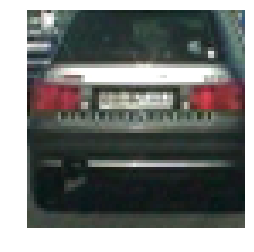

get_all_features image shape (64, 64, 3)


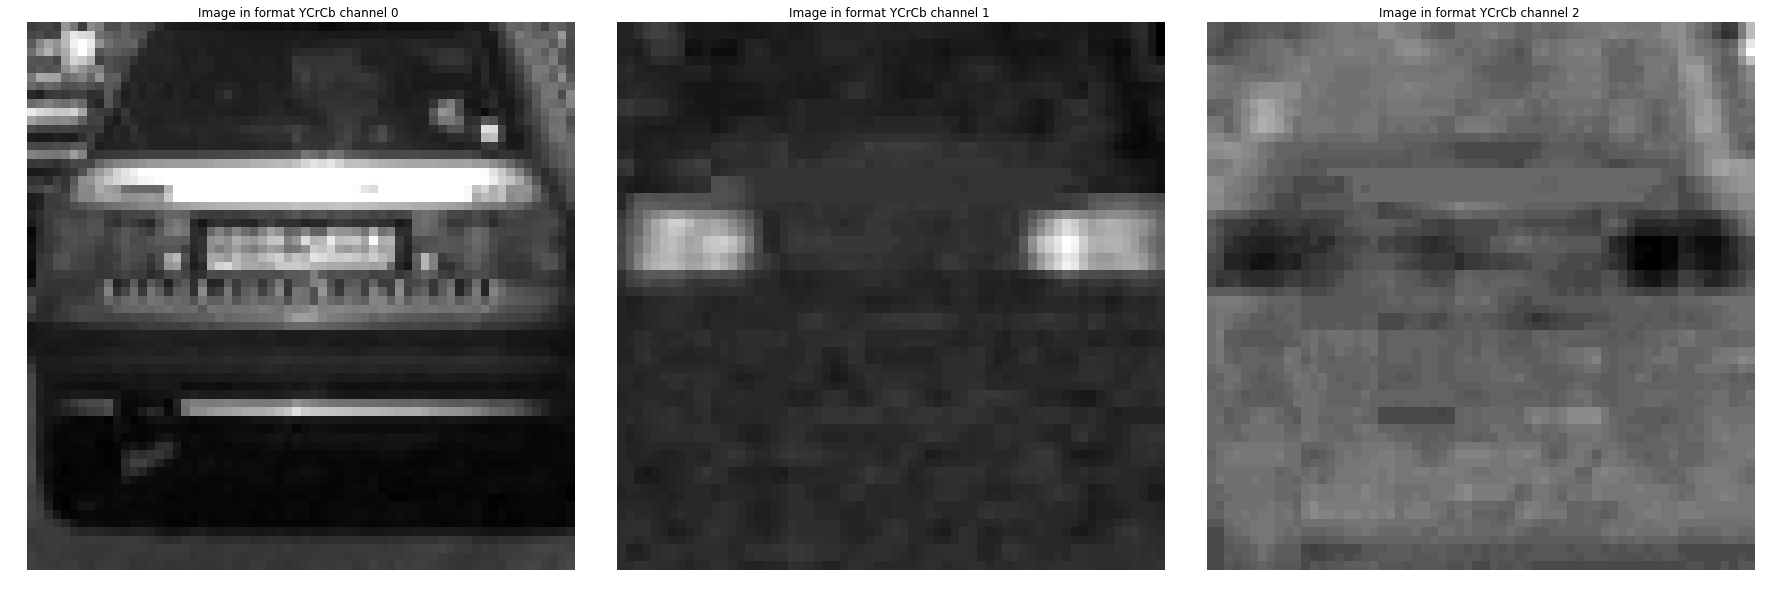

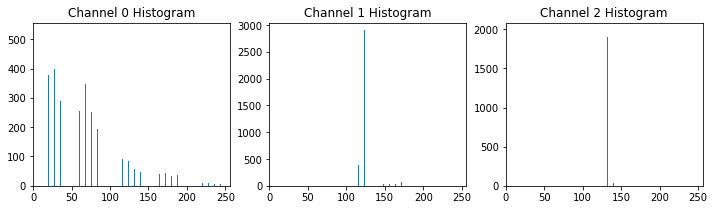

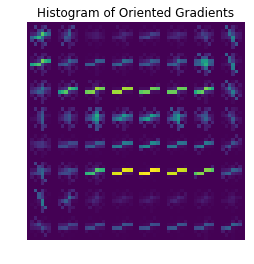

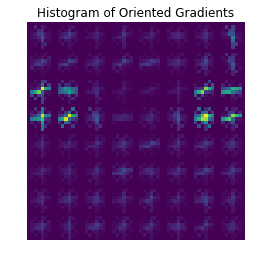

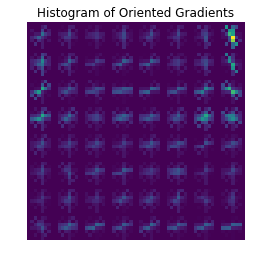

(8460,)

In [5]:
import cv2
image = cv2.imread('vehicles/GTI_MiddleClose/image0110.png')
image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# color space = RGB, HSV, LUV, HLS, YUV, YCrCb
extractor = image_features_extractor(color_space= 'YCrCb' #'YCrCb'
                                    ,pix_per_cell=8
                                    ,cell_per_block=2
                                     
                                    ,orient=9
                                    ,spatial_feat = True     # Spatial features on or off
                                    ,hist_feat = True        # Histogram features on or off
                                    ,hog_feat = True  
                                    ,spatial_size = (32, 32)
                                    ,bins_range=(0, 256)
                                    ,nbins=32
                                    , debug=True
                                    , image_size = (64,64)  
                                    )
plt.imshow(image)
plt.axis("off")
plt.show()

all_features = extractor.get_all_features(image)
all_features.shape


### Defining the classifier Neural Network

In [30]:
class classifier:
    def __init__(self, car_features, notcar_features):
        self.car_features = car_features
        self.notcar_features = notcar_features
                 
    def train(self, parameters=[1, 10], epochs=20,batch_size = 32,verbose =False):
        
        X = np.vstack((self.car_features, self.notcar_features)).astype(np.float64)                        

        print (".....Scaling...")
        # Fit a per-column scaler
        self.X_scaler = StandardScaler().fit(X)
        
        # Apply the scaler to X
        scaled_X = self.X_scaler.transform(X)
        print (scaled_X)
        
        y = np.hstack((np.ones(len(self.car_features)), np.zeros(len(self.notcar_features))))

        from sklearn.model_selection import train_test_split

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            scaled_X, y, test_size=0.1, random_state=rand_state)

        #################
        # #### START TRAINING 
        #################

        import time

        print ( "Start training ... ")
        t=time.time()
#         self.clf = tree.DecisionTreeRegressor()
#         self.clf = svm.LinearSVC()

        ### Grid search SVC
#         Cs = [0.001, 0.01, 0.1, 1, 10]
#         gammas = [0.001, 0.01, 0.1, 1]
#         param_grid = {'C': Cs, 'gamma' : gammas}
#         self.clf = GridSearchCV(SVC(kernel='rbf'), param_grid)
#         self.clf.fit(X_train, y_train)
        
#         self.clf = SVC(kernel='poly')
#         self.clf.fit(X_train, y_train)
        from keras.models import Sequential
        from keras.layers import Dense, Dropout
        from keras.utils import to_categorical
        # data = array(detector.y_train)
        # data
        
        self.clf = Sequential()
        
        self.clf.add(Dense(32, input_shape=(len(self.car_features[0]),), name="dense1"))
        self.clf.add(Dense(64, activation='relu', name="dense2"))
        self.clf.add(Dropout(0.2))
        self.clf.add(Dense(64, activation='relu', name="dense3"))
        self.clf.add(Dense(1024, activation='relu', name="dense4"))
        self.clf.add(Dropout(0.2))
        self.clf.add(Dense(1, activation='sigmoid', name="final"))

        
        self.clf.compile('adam', 'binary_crossentropy', ['accuracy'])

            
        history = self.clf.fit(self.X_train, self.y_train,
                    batch_size=batch_size,
                    epochs = epochs,
                    verbose=verbose,
                    shuffle=True,
                    validation_split=0.1,           
                    )
                  
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train the classifier...')

        # Check the score of the SVC
        score = self.clf.evaluate(self.X_test, self.y_test)

#         print('Test Accuracy of SVC = ', round(self.clf.score(X_test, y_test), 4))
        print( " ")
        print('Test Accuracy of classifier = ' + str(score[1]))


    def save_classifier(self):
        self.clf.save("keras_model.h5")
        
        import pickle
#         # save the classifier
#         with open('car_detection_classifier.pkl', 'wb') as fid:
#             pickle.dump(self.clf, fid) 
            
        with open('X_scaler.pkl', 'wb') as fid:
            pickle.dump(self.X_scaler, fid) 
        print (" .. classifier saved ")    

    def load_classifier(self):
        import pickle
        # save the classifier
#         with open('car_detection_classifier.pkl', 'rb') as fid:
#             self.clf = pickle.load(fid)
        from keras.models import load_model
        self.clf = load_model("keras_model.h5")
        
        with open('X_scaler.pkl', 'rb') as fid:
            self.X_scaler = pickle.load(fid)

        print (" .. classifier loaded ")  

### Features extraction and Classifier training

In [6]:
extractor.debug = False

detector = image_car_detector(extractor) #, limit_images= 2000)

detector.load_images_list()

detector.extract_imgs_features()


subfolder = vehicles/other
subfolder = vehicles/GTI_Left
subfolder = vehicles/GTI_MiddleClose
subfolder = vehicles/KITTI_extracted
subfolder = vehicles/GTI_Right
subfolder = vehicles/GTI_Far
 processing 8804 images 
 
 Extracting features from cars ....
 .. completed ( features per image = 8460)
 
 Extracting features from non cars ....
 .. completed ( features per image = 8460)
 


In [23]:
cars_classifier = classifier(detector.car_features, detector.notcar_features)
# cars_classifier.train(epochs=200,batch_size=128, verbose=False)

# cars_classifier.save_classifier()
cars_classifier.load_classifier()

.....Scaling...
[[-1.05620052  0.77824326 -0.37771821 ..., -0.74804179 -0.42690517
  -0.46075222]
 [-0.51908478 -0.25280414 -0.19862347 ...,  2.20281424 -0.62212189
  -0.46075222]
 [-0.94877738  0.54912161 -0.37771821 ..., -0.74691361 -0.62212189
  -0.46075222]
 ..., 
 [-0.64441179  0.54912161 -0.73590769 ..., -0.75867946  3.12525827
  -0.46075222]
 [ 0.12545411  1.0073649  -0.37771821 ..., -0.75867946 -0.62212189
  -0.46075222]
 [-0.26843077 -0.59648661  0.15956601 ...,  1.62221713  0.89022932
  -0.46075222]]
Start training ... 
120.38 Seconds to train the classifier...
3360/3522 [===========================>..] - ETA: 0s 
Test Accuracy of classifier = 0.991766042022
 .. classifier saved 
 .. classifier loaded 


### TESTING NEURAL NETWORK CLASSIFIER

In [24]:
import cv2

print ( "*************************************************************")        
print ( "** TESTING NEURAL NETWORK CLASSIFIER .....") 
print ( "*************************************************************")        


def classify(file):
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    temp_features = extractor.get_all_features(image)
    # Scale extracted features to be fed to classifier
    temp_features = cars_classifier.X_scaler.transform(np.array(temp_features).reshape(1, -1))
    # Predict using your classifier
    prediction = cars_classifier.clf.predict(temp_features)
    return prediction

corrected_predictions = 0
wrong_predictions = 0

######
#### cars 
######
print ( " Predicting CARS")
for folder  in  sorted(glob.glob('train_data/vehicles/*')):
    print ( " Predicting CARS folder " + str(folder))
    for file in glob.glob(folder+ "/*"):
        prediction = classify(file)
        if prediction == 1:
            corrected_predictions +=1
        else:
            wrong_predictions +=1
    print ("                                     ..... correct= {} , wrong={} "\
           .format(corrected_predictions,wrong_predictions ))

######
#### NON cars 
######
print ( " ")
print ( " Predicting NON CARS")
for folder  in  sorted(glob.glob('train_data/non-vehicles/*')):
    print ( " Predicting NON CARS folder " + str(folder))
    for file in glob.glob(folder + "/*"):
        prediction = classify(file)
        if prediction == 0:
            corrected_predictions +=1
        else:
            wrong_predictions +=1
    print ("                                     ..... correct= {} , wrong={} "\
           .format(corrected_predictions,wrong_predictions ))

print ( "*************************************************************")        
print ( "**")        
print ( "** Corrected predictions {}".format(corrected_predictions))        
print ( "** Wrong     predictions {}".format(wrong_predictions))        
print ( "*************************************************************")        


*************************************************************
** Predicting .....
*************************************************************
 Predicting CARS
 Predicting CARS folder vehicles/GTI_Far
                                     ..... correct= 811 , wrong=23 
 Predicting CARS folder vehicles/GTI_Left
                                     ..... correct= 1693 , wrong=50 
 Predicting CARS folder vehicles/GTI_MiddleClose
                                     ..... correct= 2106 , wrong=56 
 Predicting CARS folder vehicles/GTI_Right
                                     ..... correct= 2742 , wrong=84 
 Predicting CARS folder vehicles/KITTI_extracted
                                     ..... correct= 8699 , wrong=93 
 Predicting CARS folder vehicles/other
                                     ..... correct= 8710 , wrong=94 
 
 Predicting NON CARS
 Predicting NON CARS folder non-vehicles/Extras
                                     ..... correct= 13606 , wrong=266 
 Predicting NON CARS 

### Re-Defining the classifier as Svm


In [7]:
class classifier():
    def __init__(self, car_features, notcar_features):
        self.car_features = car_features
        self.notcar_features = notcar_features
                 
    def train(self, parameters=[1, 10], epochs=20,batch_size = 32,verbose =False):
        
        X = np.vstack((self.car_features, self.notcar_features)).astype(np.float64)                        

        print (".....Scaling...")
        # Fit a per-column scaler
        self.X_scaler = StandardScaler().fit(X)
        
        # Apply the scaler to X
        scaled_X = self.X_scaler.transform(X)
        y = np.hstack((np.ones(len(self.car_features)), np.zeros(len(self.notcar_features))))

        from sklearn.model_selection import train_test_split

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            scaled_X, y, test_size=0.1, random_state=rand_state)

        #################
        # #### START TRAINING 
        #################

        import time

        print ( "Start training ... ")
        t=time.time()
        self.clf = svm.LinearSVC()

        self.clf.fit(self.X_train, self.y_train)
        
        
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train the classifier...')

        # Check the score of the SVC
        score = self.clf.score(self.X_test, self.y_test)

        print( " ")
        print('Test Accuracy of classifier = ' + str(score))


    def save_classifier(self):
        
        import pickle
        # save the classifier
        with open('car_detection_classifier.pkl', 'wb') as fid:
            pickle.dump(self.clf, fid) 
            
        with open('X_scaler.pkl', 'wb') as fid:
            pickle.dump(self.X_scaler, fid) 
        print (" .. classifier saved ")    

    def load_classifier(self):
        import pickle
        # save the classifier
        with open('car_detection_classifier.pkl', 'rb') as fid:
            self.clf = pickle.load(fid)
        
        with open('X_scaler.pkl', 'rb') as fid:
            self.X_scaler = pickle.load(fid)

        print (" .. classifier loaded ")  

#### training the SVM classifier


In [8]:
cars_classifier = classifier(detector.car_features, detector.notcar_features)
cars_classifier.train()

cars_classifier.save_classifier()
cars_classifier.load_classifier()


.....Scaling...
Start training ... 
19.11 Seconds to train the classifier...
 
Test Accuracy of classifier = 0.989210675752
 .. classifier saved 
 .. classifier loaded 


### TESTING SVM CLASSIFIER

In [9]:
import cv2

print ( "*************************************************************")        
print ( "** TESTING SVM classifier.....") 
print ( "*************************************************************")        


def classify(file):
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    temp_features = extractor.get_all_features(image)
    # Scale extracted features to be fed to classifier
    temp_features = cars_classifier.X_scaler.transform(np.array(temp_features).reshape(1, -1))
    # Predict using your classifier
    prediction = cars_classifier.clf.predict(temp_features)
    return prediction

corrected_predictions = 0
wrong_predictions = 0

######
#### cars 
######
print ( " Predicting CARS")
for folder  in  sorted(glob.glob('train_data/vehicles/*')):
    print ( " Predicting CARS folder " + str(folder))
    for file in glob.glob(folder+ "/*"):
        prediction = classify(file)
        if prediction == 1:
            corrected_predictions +=1
        else:
            wrong_predictions +=1
    print ("                                     ..... correct= {} , wrong={} "\
           .format(corrected_predictions,wrong_predictions ))

######
#### NON cars 
######
print ( " ")
print ( " Predicting NON CARS")
for folder  in  sorted(glob.glob('train_data/non-vehicles/*')):
    print ( " Predicting NON CARS folder " + str(folder))
    for file in glob.glob(folder + "/*"):
        prediction = classify(file)
        if prediction == 0:
            corrected_predictions +=1
        else:
            wrong_predictions +=1
    print ("                                     ..... correct= {} , wrong={} "\
           .format(corrected_predictions,wrong_predictions ))

print ( "*************************************************************")        
print ( "**")        
print ( "** Corrected predictions {}".format(corrected_predictions))        
print ( "** Wrong     predictions {}".format(wrong_predictions))        
print ( "*************************************************************")        


*************************************************************
** TESTING SVM classifier.....
*************************************************************
 Predicting CARS
 Predicting CARS folder vehicles/GTI_Far
                                     ..... correct= 831 , wrong=3 
 Predicting CARS folder vehicles/GTI_Left
                                     ..... correct= 1737 , wrong=6 
 Predicting CARS folder vehicles/GTI_MiddleClose
                                     ..... correct= 2156 , wrong=6 
 Predicting CARS folder vehicles/GTI_Right
                                     ..... correct= 2819 , wrong=7 
 Predicting CARS folder vehicles/KITTI_extracted
                                     ..... correct= 8784 , wrong=8 
 Predicting CARS folder vehicles/other
                                     ..... correct= 8796 , wrong=8 
 
 Predicting NON CARS
 Predicting NON CARS folder non-vehicles/Extras
                                     ..... correct= 13862 , wrong=10 
 Predicting NON C

### Keras Convolutional Neural Network

In [100]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Lambda
from keras import backend as K

In [198]:
class classifier:
    def __init__(self, folder):
        print ( " Initializing.... ")
        self.datagen = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True)

        self.train_datagen = ImageDataGenerator(
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

        self.train_generator = train_datagen.flow_from_directory(
            folder,
            target_size=(64, 64),
            batch_size=32,
            class_mode='binary', shuffle=True)
        
        
        
        a = cars_classifier.train_generator.class_indices
        self.dict = dict(zip(a.values(), a.keys()))

    def prediction (self,image):
        
        test_images = []
        test_images.append(image)
        image2 =  np.array(test_images)
        prediction = self.clf.predict(image2).squeeze() 
#         print ( "prediction = " + str(prediction ))
        if prediction < 0.51:
            prediction = 0 
        else:
            prediction = 1
    
#         return self.dict[self.clf.predict(image2) ]
        return self.decode_prediction(prediction)

    
    def decode_prediction (self,prediction):
        return self.dict[prediction]
                 
    def train(self, epochs=20,steps_per_epochs = 200):
        if K.image_data_format() == 'channels_first':
            input_shape = (3, 64, 64)
        else:
            input_shape = (64, 64, 3)
        print (" input_shape =" + str(input_shape) )

        self.clf =  Sequential()
        self.clf.add(Lambda(lambda x: x/127.5 - 1,  input_shape=input_shape))
        self.clf.add(Conv2D(32, (3, 3)))
        self.clf.add(Activation('relu'))
        self.clf.add(MaxPooling2D(pool_size=(2, 2)))

        self.clf.add(Conv2D(32, (3, 3)))
        self.clf.add(Activation('relu'))
        self.clf.add(MaxPooling2D(pool_size=(2, 2)))

        self.clf.add(Conv2D(64, (3, 3)))
        self.clf.add(Activation('relu'))
        self.clf.add(MaxPooling2D(pool_size=(2, 2)))

        self.clf.add(Flatten())
        self.clf.add(Dense(64))
        self.clf.add(Activation('relu'))
        self.clf.add(Dropout(0.5))
        self.clf.add(Dense(1))
        self.clf.add(Activation('sigmoid'))
        self.clf.compile(loss='binary_crossentropy',  optimizer='adam',metrics=['accuracy'])

        self.clf.fit_generator(
                        self.train_generator,
                        epochs=epochs, steps_per_epoch=steps_per_epochs) # = steps_per_epochs)
# ,
#         shuffle=True)



    def save_classifier(self):
        self.clf.save("kerasCNN_model.h5")
        
        import pickle
#         # save the classifier
#         with open('car_detection_classifier.pkl', 'wb') as fid:
#             pickle.dump(self.clf, fid) 
            
        print (" .. classifier saved ")    

    def load_classifier(self):
        import pickle
        # save the classifier
#         with open('car_detection_classifier.pkl', 'rb') as fid:
#             self.clf = pickle.load(fid)
        from keras.models import load_model
        self.clf = load_model("kerasCNN_model.h5")
        
        print (" .. classifier loaded ")  

In [199]:
cars_classifier = classifier("train_data")
cars_classifier.train(100,556)

cars_classifier.save_classifier()
cars_classifier.load_classifier()

 Initializing.... 
Found 17795 images belonging to 2 classes.
 input_shape =(64, 64, 3)
Epoch 1/1
556/556 [==============================] - 17s - loss: 0.1820 - acc: 0.9215    
 .. classifier saved 
 .. classifier loaded 


### TESTING CNN CLASSIFIER

In [204]:
# import cv2

# print ( "*************************************************************")        
# print ( "** TESTING SVM classifier.....") 
# print ( "*************************************************************")        
image = cv2.imread("train_data/vehicles/GTI_Far/image0000.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print ( " prediction CARS = " + str(cars_classifier.prediction(image)))

image = cv2.imread("train_data/vehicles/GTI_Far/image0010.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print ( " prediction CARS = " + str(cars_classifier.prediction(image)))

image = cv2.imread("train_data/vehicles/GTI_Far/image0021.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print ( " prediction CARS = " + str(cars_classifier.prediction(image)))


image = cv2.imread("train_data/non-vehicles/Extras/extra1.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
test_images.append(image)
np.array(test_images).shape

print ( " prediction non cars = " + str(cars_classifier.prediction(image)))
image = cv2.imread("train_data/non-vehicles/Extras/extra2.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print ( " prediction non cars = " + str(cars_classifier.prediction(image)))



def classify(file):
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    prediction = cars_classifier.prediction(image)
    return prediction

corrected_predictions = 0
wrong_predictions = 0

######
#### cars 
######
print ( " Predicting CARS")
for folder  in  sorted(glob.glob('train_data/vehicles/*')):
    print ( " Predicting CARS folder " + str(folder))
    for file in glob.glob(folder+ "/*"):
        prediction = classify(file)
        if prediction == "vehicles":
            corrected_predictions +=1
        else:
            wrong_predictions +=1
    print ("                                     ..... correct= {} , wrong={} "\
           .format(corrected_predictions,wrong_predictions ))

######
#### NON cars 
######
print ( " ")
print ( " Predicting NON CARS")
for folder  in  sorted(glob.glob('train_data/non-vehicles/*')):
    print ( " Predicting NON CARS folder " + str(folder))
    for file in glob.glob(folder + "/*"):
        prediction = classify(file)
        if prediction == "non-vehicles":
            corrected_predictions +=1
        else:
            wrong_predictions +=1
    print ("                                     ..... correct= {} , wrong={} "\
           .format(corrected_predictions,wrong_predictions ))

print ( "*************************************************************")        
print ( "**")        
print ( "** Corrected predictions {}".format(corrected_predictions))        
print ( "** Wrong     predictions {}".format(wrong_predictions))        
print ( "*************************************************************")        


 prediction CARS = vehicles
 prediction CARS = vehicles
 prediction CARS = non-vehicles
 prediction non cars = non-vehicles
 prediction non cars = non-vehicles
 Predicting CARS
 Predicting CARS folder train_data/vehicles/GTI_Far
                                     ..... correct= 732 , wrong=102 
 Predicting CARS folder train_data/vehicles/GTI_Left
                                     ..... correct= 1599 , wrong=144 
 Predicting CARS folder train_data/vehicles/GTI_MiddleClose
                                     ..... correct= 2017 , wrong=145 
 Predicting CARS folder train_data/vehicles/GTI_Right
                                     ..... correct= 2613 , wrong=213 
 Predicting CARS folder train_data/vehicles/KITTI_extracted
                                     ..... correct= 8536 , wrong=256 
 Predicting CARS folder train_data/vehicles/other
                                     ..... correct= 8548 , wrong=256 
 
 Predicting NON CARS
 Predicting NON CARS folder train_data/non-vehicles/

In [ ]:
class window_extractor:
    def __init__(self, image,               \
                 window_dimension=32,  \
                 x_start_stop=[None, None], \
                 y_start_stop=[350, None], \
                 x_overlap=0.5, y_overlap=0.5):
        
        self.image           = image
        self.xy_window       = (window_dimension, window_dimension)
        self.xy_overlap      = (x_overlap, y_overlap)
        self.x_start_stop    = x_start_stop
        self.y_start_stop    = y_start_stop
        
        # If x and/or y start/stop positions not defined, set to image size
        #     print (x_start_stop)
        if self.x_start_stop[0] == None:
            self.x_start_stop[0] = 0
        if self.x_start_stop[1] == None:
            self.x_start_stop[1] = self.image.shape[1]
        if self.y_start_stop[0] == None:
            self.y_start_stop[0] = 0
        if self.y_start_stop[1] == None:
            self.y_start_stop[1] = self.image.shape[0]

        # Compute the span of the region to be searched    
        self.xspan = self.x_start_stop[1] - self.x_start_stop[0]
        self.yspan = self.y_start_stop[1] - self.y_start_stop[0]
        
        # Compute the number of pixels per step in x/y
        self.nx_pix_per_step = np.int(self.xy_window[0]*(1 - self.xy_overlap[0]))
        self.ny_pix_per_step = np.int(self.xy_window[1]*(1 - self.xy_overlap[1]))
        
        # Compute the number of windows in x/y
        self.nx_buffer = np.int(self.xy_window[0]*(self.xy_overlap[0]))
        self.ny_buffer = np.int(self.xy_window[1]*(self.xy_overlap[1]))
        self.nx_windows = np.int((self.xspan-self.nx_buffer)/self.nx_pix_per_step) 
        self.ny_windows = np.int((self.yspan-self.ny_buffer)/self.ny_pix_per_step) 



    def get_windows(self):
        # Initialize a list to append window positions to
        self.window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(self.ny_windows):
            for xs in range(self.nx_windows):
                # Calculate window position
                startx = xs*self.nx_pix_per_step + self.x_start_stop[0]
                endx = startx + self.xy_window[0]
                starty = ys*self.ny_pix_per_step + self.y_start_stop[0]
                endy = starty + self.xy_window[1]
                # Append window position to list
                self.window_list.append([startx, starty, endx, endy])
        # Return the list of windows
        return self.window_list
    
    def draw_boxes(self,hot_windows, color=(0, 0, 255), thick=6):
        # Make a copy of the image
        imcopy = np.copy(self.image)
        tmp_window_list = hot_windows
        for bbox in tmp_window_list:
#             print ("bbox = " + str(bbox))
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, (bbox[0], bbox[1]),(bbox[2], bbox[3]), color, thick)
        # Return the image copy with boxes drawn
        return imcopy

    

In [ ]:
from scipy.ndimage.measurements import label

class heat_map:
    def __init__(self, boxes_list, image):
            self.boxes = boxes_list
            self.heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
            self.image = np.copy(image)
            
    
    def add_heat(self):
        # Iterate through list of bboxes
        
        for box in self.boxes :
#             print ("box = " + str(box))
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            self.heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap

    def apply_threshold(self,threshold):
#         print (" Applying threshold = " + str(threshold))
        # Zero out pixels below the threshold
        self.heatmap[self.heatmap < threshold] = 0
        # Return thresholded map

    def draw_labeled_bboxes(self):
#         print ("draw_labeled_bboxes .... ")
        #scipy.ndimage.measurements.label
        self.labels = label(self.heatmap)
#         print ("labels = " + str(labels))
        # Iterate through all detected cars
        self.boxes = []
        for car_number in range(1, self.labels[1]+1):
#             print ( " car_number = " + str(car_number))
            # Find pixels with each car_number label value
            nonzero = (self.labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ([np.min(nonzerox), np.min(nonzeroy),np.max(nonzerox), np.max(nonzeroy)])
#             if not self.hot_boxes_discard(bbox):
                # Draw the box on the image
            cv2.rectangle(self.image, (bbox[0], bbox[1]),(bbox[2], bbox[3]), (0,255,0), 6)
            self.boxes.append(bbox)
        # Return the image


#     def hot_boxes_discard(self, box):
#         ### discard hot boxes that are unrealistics ( bad proportion or too small for specific y-position)
#         box = np.copy(box).ravel()
        
#         print ( box )
#         x_dimension = box[2] - box[0]
#         y_dimension = box[3] - box[1]
#         ratio = x_dimension / y_dimension
#         discard = False

#         if ratio < 0.7 or ratio > 1.7:
#             print( " discard because of ratio  " +str(ratio))
#             discard = True
#         if x_dimension < 40 and box[1] > 300:
#             print ( " discard because of x_dimension  " +str(x_dimension))
#             print ( "                    box[1]       " +str(box[1]))

#             discard = True

#         return discard

### Defining the class pipeline

In [ ]:
class pipeline:
    def __init__(self, extractor, cars_classifier, debug=False):
        self.detector = image_car_detector(extractor)
        self.cars_classifier = cars_classifier
        self.cars_classifier.load_classifier()
        self.debug= debug
        self.boxes_history = []
        self.discarded = 0

    def insert_boxes_history(self, boxes):
        self.boxes_history.append(boxes)
        ### keeping only the last 3 fits
        self.boxes_history = self.boxes_history[-3:]

        
    def searchfor_windows_first(self):
            self.windows = []
            ##########  scale = 1
            windows_ext = window_extractor(self.image, 
                                           window_dimension=64, 
                                           x_overlap = 0.5,
                                           y_overlap = 0.8,
                                           x_start_stop = [340,None],
                                           y_start_stop = [390,510])
            
            for x in windows_ext.get_windows():
                 self.windows.append(x)

            ##########  scale = 1.25      
            windows_ext = window_extractor(image, 
                                           window_dimension=int(64*1.25), 
                                           x_overlap = 0.5,
                                           y_overlap = 0.8,
                                           x_start_stop = [340,None],
                                           y_start_stop = [400,560])
            for x in windows_ext.get_windows():
                 self.windows.append(x)


            # ###########  scale = 1.5     
            windows_ext = window_extractor(image, 
                                           window_dimension=int(64*1.5), 
                                           x_overlap = 0.5,
                                           y_overlap = 0.8,
                                           x_start_stop = [340,None],
                                           y_start_stop = [400,600])
            for x in windows_ext.get_windows():
                 self.windows.append(x)

        
            # ###########  scale = 1.75   
            windows_ext = window_extractor(image, 
                                           window_dimension=int(64*1.75), 
                                           x_overlap = 0.5,
                                           y_overlap = 0.8,
                                           x_start_stop = [340,None],
                                           y_start_stop = [400,656])
            for x in windows_ext.get_windows():
                 self.windows.append(x)





    def searchfor_windows_second(self, x_start_stop,y_start_stop):
            

            w_dim = int(( y_start_stop[0] /400 ) * 70 )
            windows_ext = window_extractor(self.image, 
                                           window_dimension=w_dim, 
                                           x_overlap = 0.5,
                                           y_overlap = 0.8,
                                           x_start_stop=x_start_stop,
                                           y_start_stop=y_start_stop)
            
            for x in windows_ext.get_windows():
                 self.windows.append(x)

            w_dim = int(w_dim * 1.3)
            windows_ext = window_extractor(self.image, 
                                           window_dimension=w_dim, 
                                           x_overlap = 0.5,
                                           y_overlap = 0.8,
                                           x_start_stop=x_start_stop,
                                           y_start_stop=y_start_stop)
            
            for x in windows_ext.get_windows():
                 self.windows.append(x)

                    
            if self.debug:
                image_tmp = windows_ext.draw_boxes(self.windows)
                return image_tmp
            else:
                return None



    # search with different steps
    # first search is with big windows and low number of windows to get a speed overview of the car positions
    # secondly using the car position I will "shut" more smaller sliding windows in that area to find the 
    #          exact box around the car
    def search_cars_by_steps(self,image):
#         print ( " image.shape ******* "+ str(image.shape))
#         print ( " image ******* "+ str(image))

#         plt.imshow(image)
#         plt.show()
        
        self.image = image 
#         print ( " self.image.shape " + str(self.image.shape))

        
        ######################################################
        ##              FIRST         STEP
        ######################################################

        self.windows = []
        self.hot_windows = []
        
        ########
        # creating a list of boxes
        ########
        tmp_image = self.searchfor_windows_first()
        if self.debug:
            image_tmp = window_extractor(self.image).draw_boxes(self.windows)
            plt.imshow(image_tmp)    
            plt.title(" Boxes drawn on the image ")
            plt.show()

            

        ########
        # search for car detection in the above calculated boxes
        ########
        self.hot_windows = []
        self.hot_windows = self.detector.search_windows(self.image, self.windows, cars_classifier=self.cars_classifier)
        if self.debug:
            tmp_image_hot = window_extractor(self.image).draw_boxes(self.hot_windows)
            plt.imshow(tmp_image_hot)    
            plt.title(" Car boxes detected ")
            plt.show()

            
        ########
        # heat map
        ########
        self.heat = heat_map(self.hot_windows, self.image)
        self.heat.add_heat()
        self.heat.apply_threshold(threshold=4)
#         self.heat.draw_labeled_bboxes()

        ########
        # discard unrealistic boxes
        ########
        number_of_boxes =  len(np.array(self.heat.boxes))   
        self.heat.boxes = np.array(self.heat.boxes).reshape(number_of_boxes,4)


        self.heat.draw_labeled_bboxes()
        if self.debug:
            plt.imshow(self.heat.image)    
            plt.title(" First heat map")

            plt.show()


# #         return tmp_image, tmp_image_hot, self.heat.image


        ######################################################
        ##              SECOND         STEP
        ######################################################


#         if self.debug: print ( " Second Step ....")
#         self.windows = []
#         for box in self.heat.boxes:
#             x_start = int((box[0][0] ) * .95)
#             x_stop  = int((box[1][0] ) * 1.05)
#             y_start = int((box[0][1] ) * .95)
#             y_stop  = int((box[1][1] ) * 1.05)

# #             print (" box = " + "x_start= " + str(x_start) +  " , "  
# #                              + "x_stop= "  + str(x_stop)  +  " , "  
# #                              + "y_start= " + str(y_start) +  " , "  
# #                              + "y_stop= "  + str(y_stop)  +  " , "  
# #                   )
#             # creating a list of boxes
#             self.searchfor_windows_second( x_start_stop=[x_start,x_stop],
#                                            y_start_stop=[y_start,y_stop] )

#         if self.debug:
#             image_tmp = window_extractor(self.image).draw_boxes(self.windows)
#             plt.imshow(image_tmp)    
#             plt.title(" Boxes drawn on the image (second step )")
#             plt.show()

            
#         # search for car detection in the above calculated boxes
#         if self.debug:print (" Searching for windows with cars ")
#         if self.debug:print ( " .. Number of boxes = " + str(len(self.windows)) )
#         self.hot_windows = []
#         self.hot_windows = self.detector.search_windows(self.image, self.windows)
#         if self.debug:
#             tmp_image_hot = window_extractor(self.image).draw_boxes(self.hot_windows)
#             plt.imshow(tmp_image_hot)    
#             plt.title(" Car boxes detected ")
#             plt.show()

#         ########
#         # heat map
#         ########
#         if self.debug: print ("Creating heat_map ... ")
#         self.heat = heat_map(self.hot_windows, self.image)
#         self.heat.add_heat()
#         self.heat.apply_threshold(threshold=3)
        
#         self.heat.draw_labeled_bboxes()

#         if self.debug:
#             plt.imshow(self.heat.image)    
#             plt.title(" Second heat map")

#             plt.show()


#         if self.debug: print(".... Completed")



        if self.debug:
            print ( " ")
            print (  " ------- actual self.heat.boxes = " )
            print (str(self.heat.boxes))

        
        self.insert_boxes_history(self.heat.boxes)
        
        #####################
        #### frame history averaging 
        #####################

        numbers_of_actual_boxes = len(self.heat.boxes)
        
        for i, box in enumerate(self.calc_history_average()):
            if self.debug:
                print ("*******************************")
            ## in case is missing I will append the history box
            if self.debug:
                print ( " i = " + str(i) + " numbers_of_actual_boxes = " + str(numbers_of_actual_boxes))
            if i +1 > numbers_of_actual_boxes:
                if self.debug: 
                    print ( " ****** appending "+ str(box))
                    
                self.heat.boxes = np.vstack((self.heat.boxes,box))
                numbers_of_actual_boxes += 1
            if self.debug:print ("history box average i = " + str(i) )
            if self.debug:print ("   -->  avg.   = "  + str(box) )
            if self.debug:print ("   -->  actual = " + str(self.heat.boxes[i]))
            if self.debug:print ( "  -->  mean_squared_error = " + str(self.calc_RMSE(box , self.heat.boxes[i] )))
            
            ## actual box substitution with history boxes
            if self.calc_RMSE(box , self.heat.boxes[i] ) > 5.4 and self.discarded < 3:
                print ( "Current frame discarded ")
                self.discarded += 1
                self.heat.boxes[i] = box 
            if self.debug:
                print (" ---- ")
         
        ###########################
        return self.heat.image

    def calc_RMSE(self, vector1, vector2):
        sum_squared_diff = 0
        n = 0
        for element1, element2 in zip(vector1, vector2):
            n +=1
            sum_squared_diff += (element1 - element2) **2
        mean_squared_error_result = np.sqrt(sum_squared_diff / n)
        return mean_squared_error_result
            
    def put_zero_missing_history_elements(self):
        if self.debug:
            print (" -----------------------------")
            print (" ---- put_zero_missing_history_elements ----")
            print (" -----------------------------")
            print ( pipeline1.boxes_history)
            
        self.max_length = 0
        for boxes in pipeline1.boxes_history:
#             print ( "-----------------------------")
#             print (boxes)
            len_boxes = 0
            for row in boxes:
                if np.sum(row) > 0 :
                    len_boxes +=1
            if len_boxes > self.max_length:
                self.max_length = len_boxes
        if self.debug:print (" --")

        for i, boxes in enumerate(pipeline1.boxes_history):
            if self.debug:
                print ( " ----")
                print ( " ------ processing box " + str(i))
                print ( boxes)
                print ( " ----")
                print ( " ----")

            # excluding the eventual zero boxes 
            pipeline1.boxes_history[i] = pipeline1.boxes_history[i][:self.max_length]
            
            for to_add in range ( len(boxes), self.max_length):
               if self.debug:print ( " ** adding element to box " + str(i))
               pipeline1.boxes_history[i] = np.vstack((pipeline1.boxes_history[i], [0,0,0,0]))
                
        if self.debug:print ( pipeline1.boxes_history)
        if self.debug:print (" --")




        
    def calc_history_average(self):
        
        ### fill the missing elements with zero
        self.put_zero_missing_history_elements()
        
        boxes_sum = np.zeros((self.max_length,4))
        boxes_n = np.zeros((self.max_length,4))

        if self.debug:
            print (" _----------- ")
            print (pipeline1.boxes_history)
            print (" _----------- ")

        for element in np.array(pipeline1.boxes_history):
            if self.debug:print (element )
            if self.debug:print ("####")
            n = 0
            for i,box in enumerate(element):
                # avoid the average on missing elements
                if np.sum(box) == 0:
                    pass
                else:
                    boxes_n[i] += 1
                boxes_sum[i] += box

        return boxes_sum/boxes_n

    

In [ ]:
import cv2
pipeline1 = pipeline(extractor, cars_classifier=cars_classifier, debug=True)

for image_name  in  sorted(glob.glob('test_images2/*20*')):
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_heat = pipeline1.search_cars_by_steps(image)
    print ( " *******************************************     ")
    print ( " *************** finish     ")
    print ( " *******************************************     ")
    plt.title(" pipeline output" + str(image_name))
    plt.imshow(image_heat)
    plt.show()


    


In [ ]:
pipeline1.boxes_history

In [ ]:
pipeline1 = pipeline(debug=False,extractor=extractor)
    
from moviepy.editor import VideoFileClip
output_video_name = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
clip2 = clip1.subclip(0,2)
output_video = clip2.fl_image(lambda x:pipeline1.search_cars_by_steps(x, cars_classifier)) #NOTE: this function expects color images!!
%time output_video.write_videofile(output_video_name, audio=False)
print ("Completed")

